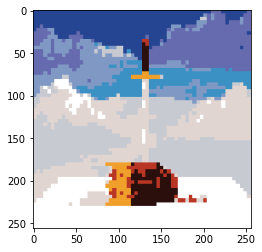

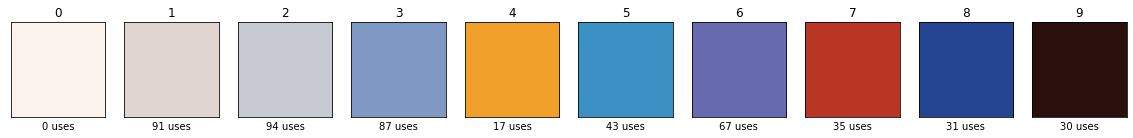

In [89]:
# from paint import discrete_color, color_cluster

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2
import torch
import os
import pandas as pd
import copy

from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

output_dir = 'deterministic_paint_instructions'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

device = "cpu" # torch.device("cuda" if torch.cuda.is_available() else "cpu")

def discrete_color(color_stroke, allowed_colors, just_inds=False): #(n*5, 3)
    allowed_colors_tensors = [torch.Tensor([allowed_colors[i]] * color_stroke.shape[0]).to(device) for i in range(len(allowed_colors))]
    
    l2_distances = torch.zeros((color_stroke.shape[0], len(allowed_colors_tensors)))
    for i in range(len(allowed_colors_tensors)):
        l2_distances[:, i] = torch.sum((color_stroke - allowed_colors_tensors[i])**2, dim=1)
        for j in range(l2_distances.shape[0]):
            color1_rgb = sRGBColor(color_stroke[j,2], color_stroke[j,1], color_stroke[j,0])
            color2_rgb = sRGBColor(allowed_colors[i][2], allowed_colors[i][1], allowed_colors[i][0])
            color1_lab = convert_color(color1_rgb, LabColor)
            color2_lab = convert_color(color2_rgb, LabColor)
            l2_distances[j, i] = delta_e_cie2000(color1_lab, color2_lab)

    color_inds = torch.argmin(l2_distances, dim=1, keepdims=True).repeat((1,3)).to(device)
    if just_inds:
        return color_inds
    
    new_color_stroke = torch.zeros(color_stroke.shape).to(device)
    for i in range(len(allowed_colors_tensors)):
        new_color_stroke = torch.where(color_inds == i, allowed_colors_tensors[i], new_color_stroke)

    return new_color_stroke

def color_cluster(img_fn, n_colors=6, width=128):
    allowed_colors = []

    img = cv2.imread(img_fn, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (width, width)) # we want bgr

    colors = img.reshape((width*width), 3) / 255

    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(colors)

    for i in range(n_colors):
        c = kmeans.cluster_centers_[i] # c is in BGR format
        allowed_colors.append(c) #BGR format appended
    return allowed_colors # They're global anyways

def save_colors(allowed_colors, actions):
    # Save the colors used as an image so you know how to mix the paints
    n_colors = len(allowed_colors)
    fig, ax = plt.subplots(1, n_colors, figsize=(2*n_colors, 2))
    i = 0 
    w = 128
    for c in allowed_colors:
        # print('[', int(255*c[2]), ', ', int(255*c[1]), ', ', int(255*c[0]), '],', end='', sep='')
        num_uses = np.sum(actions[:,12] == i)
        ax[i].imshow(np.concatenate((np.ones((w,w,1))*c[2], np.ones((w,w,1))*c[1], np.ones((w,w,1))*c[0]), axis=-1))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(i)
        ax[i].set_xlabel(str(num_uses) + ' uses')
        i += 1

    plt.savefig(os.path.join(output_dir, 'colors.png'))

def group_strokes_by_color(strokes):
    strokes = sorted(copy.deepcopy(strokes),key=lambda l:l[12], reverse=False)
    return strokes

def paint_deterministic(img_fn, n_colors=10, n_x_strokes=20, n_y_strokes=20, width=128, 
                        ignore_white_strokes=True, combine_strokes=True):
    allowed_colors = color_cluster(img_fn, n_colors=n_colors, width=128)
    
    # So when running it a few times, similar results
    allowed_colors = sorted(allowed_colors,key=lambda l:np.mean(l), reverse=True)

    img = cv2.imread(img_fn, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (width, width)) # we want bgr
    
    painting = np.ones(img.shape)

    strokes, strokes_bgr = [], []
    
    # loop through the patches, get the color and add it to the list
    for x_start in np.arange(0., 1., 1./n_x_strokes):
        x_end = x_start + (1./n_x_strokes)
        prev_color_ind = -1
        
        for y_start in np.arange(0., 1., 1./n_y_strokes):
#             if y_start > 0.33 or x_start > 0.3: continue
            y_end = y_start + (1./n_y_strokes)
            
            patch = img[int(x_start*width):int(x_end*width), int(y_start*width):int(y_end*width), :]

            color = np.median(patch, axis=(0,1))[np.newaxis]
            color = torch.from_numpy(color).to(device) / 255.

            disc_color = discrete_color(color, allowed_colors).cpu()
            disc_color_ind = discrete_color(color, allowed_colors, just_inds=True).cpu()
        
            # Ignore whites
            if ignore_white_strokes and (disc_color.mean() > 0.85):
                continue
            
            disc_color_patch = np.ones(patch.shape) * disc_color.numpy()
            painting[int(x_start*width):int(x_end*width), int(y_start*width):int(y_end*width), :] = disc_color_patch
            
            x0 = (x_start + x_end) / 2
            x1 = (x_start + x_end) / 2
            x2 = (x_start + x_end) / 2
            y0 = y_start 
            y1 = (y_start + y_end) / 2
            y2 = y_end
            
            if combine_strokes and prev_color_ind == int(disc_color_ind[0,0]):
                # elongate the stroke, don't make a new one
                prev_stroke = strokes[-1]
                prev_stroke[0:2] = x2, y2
                strokes[-1] = prev_stroke
                
                prev_stroke_bgr = strokes_bgr[-1]
                prev_stroke_bgr[0:2] = x2, y2
                strokes_bgr[-1] = prev_stroke_bgr
                continue

            prev_color_ind = (disc_color_ind[0,0])
            
            action = np.zeros((13,))

            action[0:6] = [x2, y2, x1, y1, x0, y0]
            action[10:13] = disc_color_ind.type(torch.int16)

            strokes.append(action)
            
            stroke_bgr = action.copy()
            stroke_bgr[10:13] = disc_color.type(torch.float32)
            strokes_bgr.append(stroke_bgr)
            
    strokes = np.array(strokes)
    strokes_bgr = np.array(strokes_bgr)

    plt.imshow(painting[:,:,::-1])
    plt.show()
    cv2.imwrite(os.path.join(output_dir, 'painting.jpg'), painting * 255.)
    
    save_colors(allowed_colors, strokes)
    
    df = pd.DataFrame(group_strokes_by_color(strokes))

    df.to_csv(os.path.join(output_dir, 'actions.csv'), sep=",", header=False, index=False, float_format='%.5f')

    return strokes, strokes_bgr
# paint_deterministic('image/joe.jpg', n_x_strokes=25, n_y_strokes=25, width=256, n_colors=4)
# paint_deterministic('image/odyssey.jpg', n_x_strokes=33, n_y_strokes=53, width=256, n_colors=10, ignore_white_strokes=True)
# paint_deterministic('image/joe.jpg', n_x_strokes=30, n_y_strokes=30, width=256, n_colors=6)
# paint_deterministic('image/george_condo1.png', n_x_strokes=53, n_y_strokes=53, width=256, n_colors=10, ignore_white_strokes=True);
paint_deterministic('image/george_condo1.png', n_x_strokes=60, n_y_strokes=60, width=256, n_colors=10, ignore_white_strokes=True);

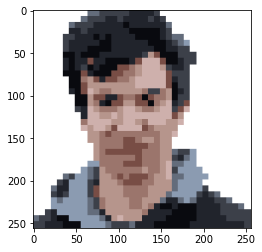

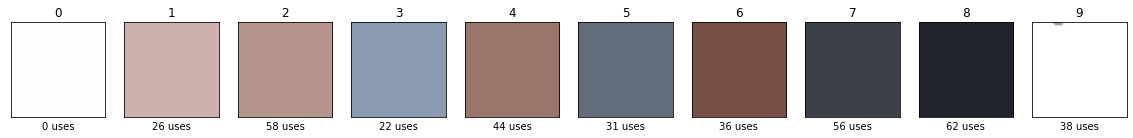

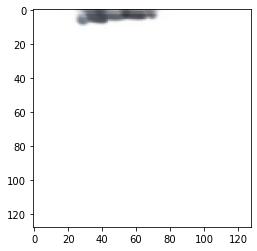

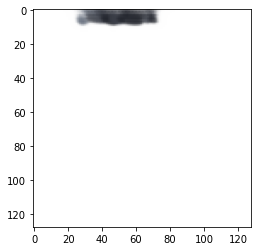

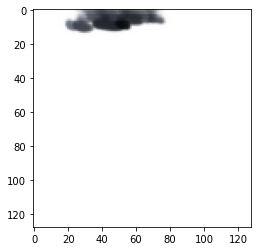

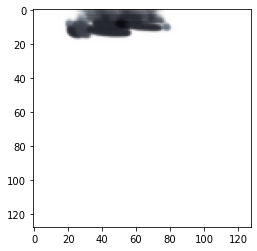

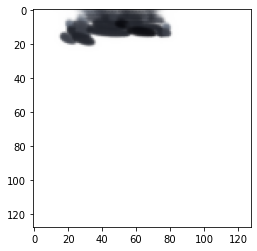

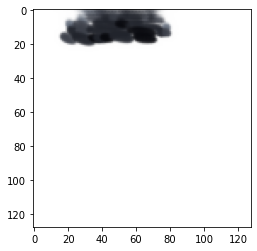

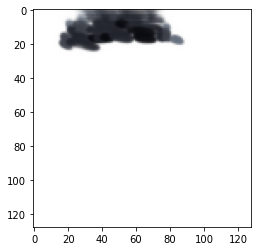

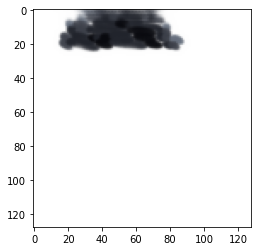

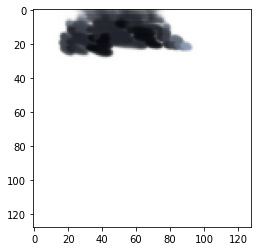

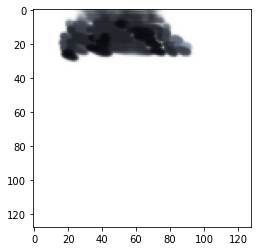

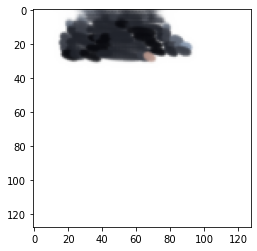

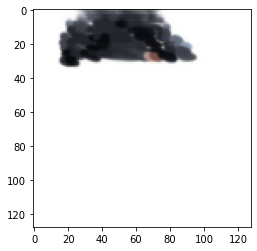

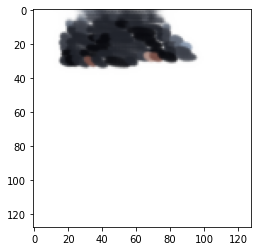

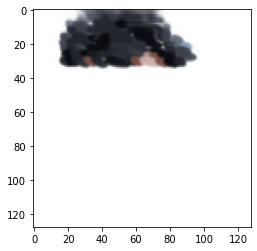

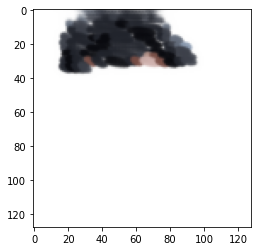

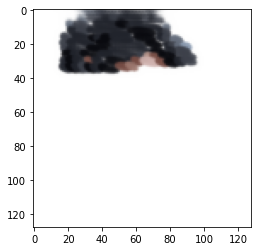

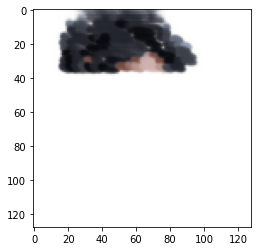

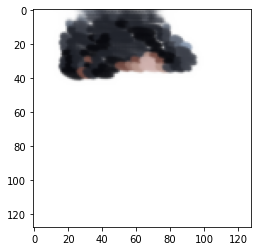

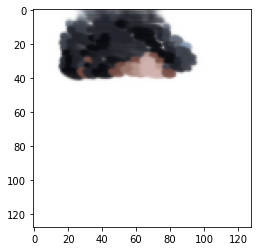

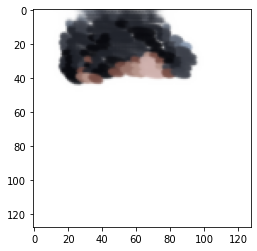

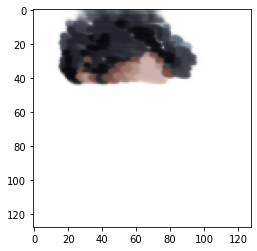

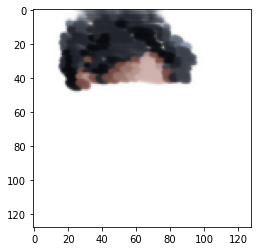

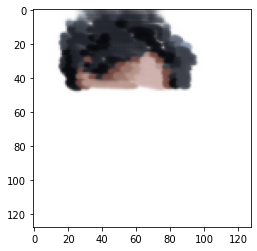

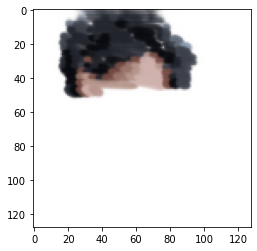

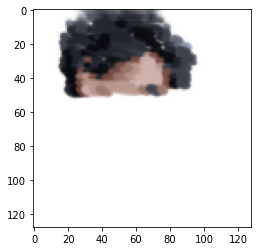

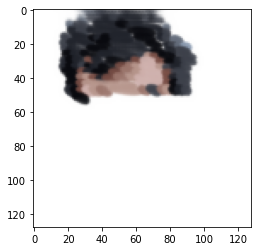

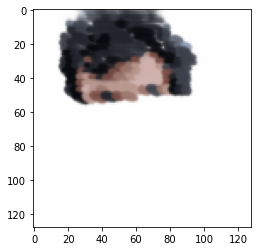

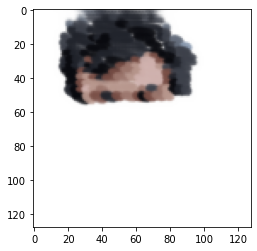

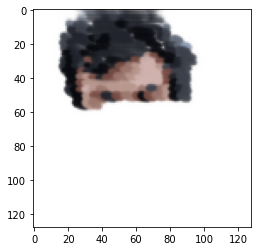

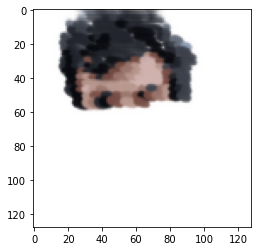

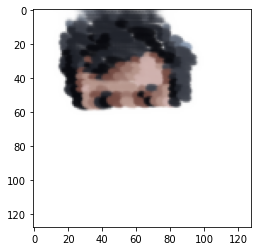

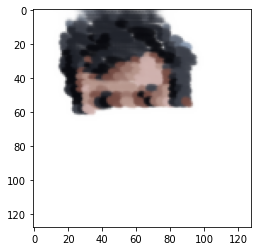

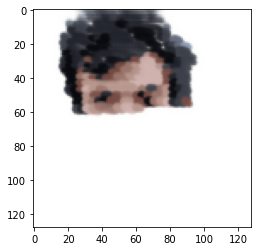

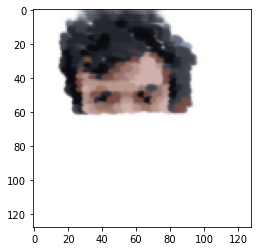

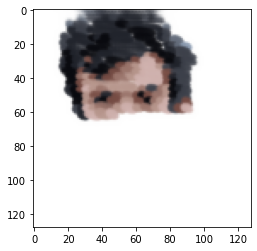

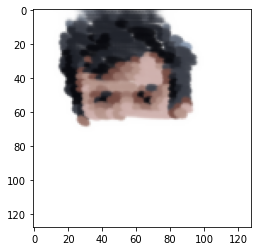

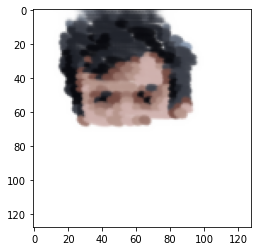

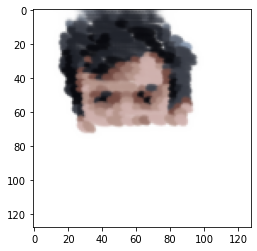

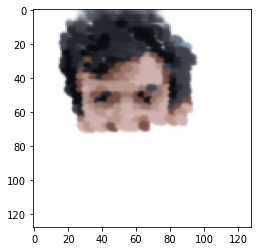

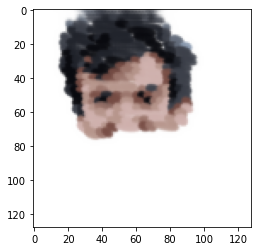

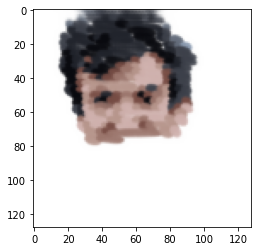

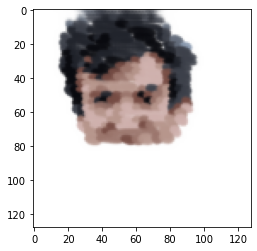

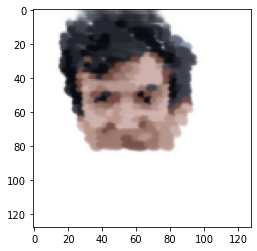

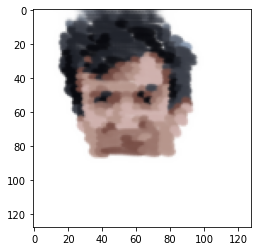

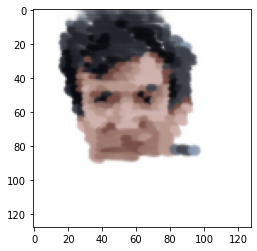

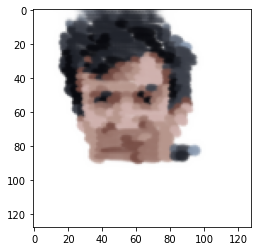

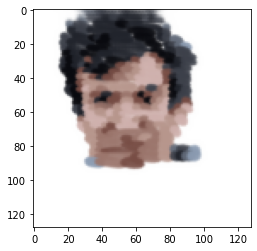

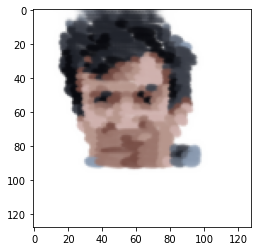

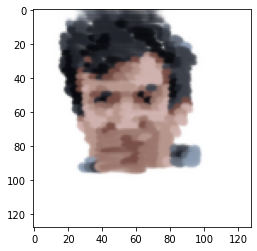

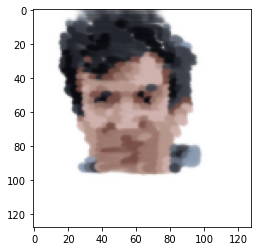

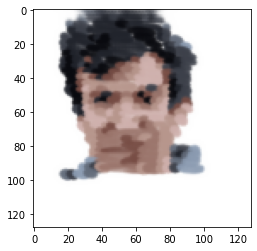

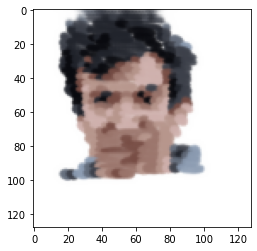

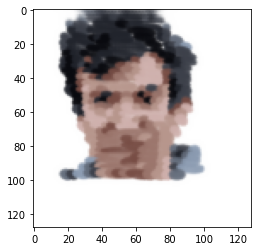

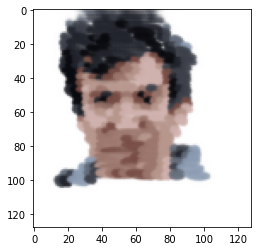

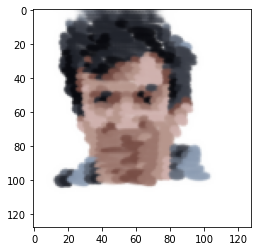

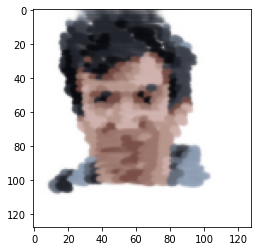

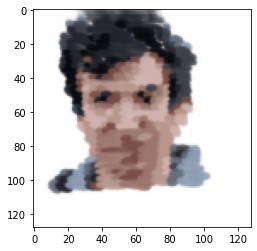

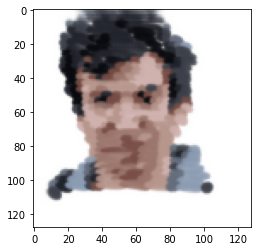

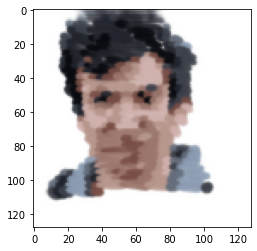

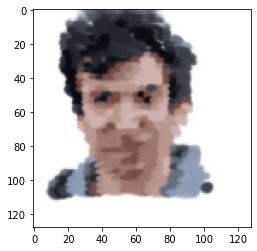

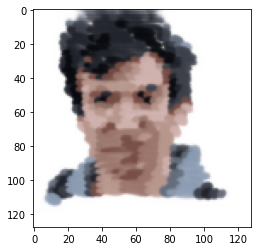

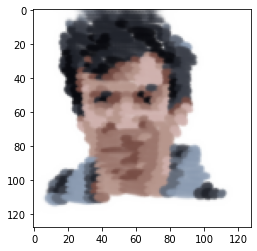

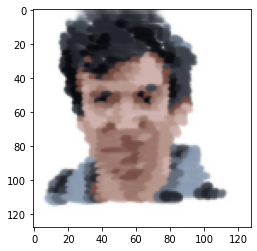

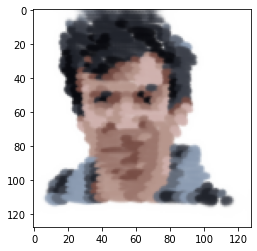

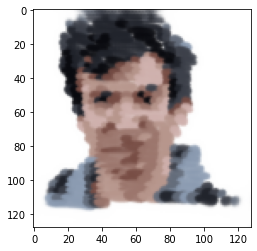

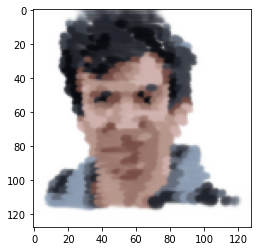

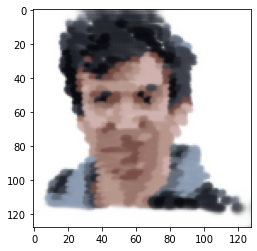

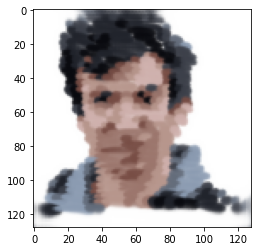

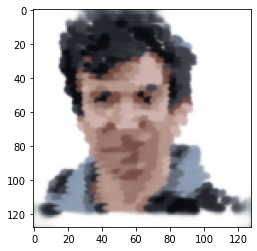

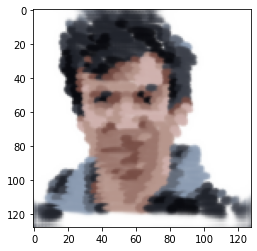

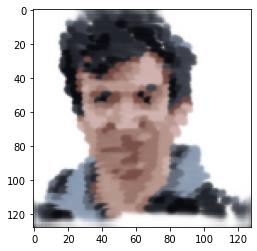

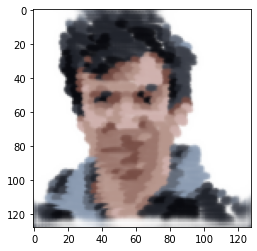

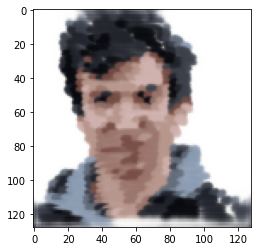

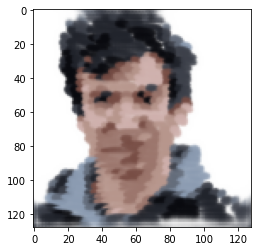

In [52]:
from paint import FCN

def res_to_img(res, imgid, divide=False):
    output = res.detach().cpu().numpy() # d * d, 3, width, width    
    output = np.transpose(output, (0, 2, 3, 1))
    if divide:
        output = small2large(output)
        output = smooth(output)
    else:
        output = output[0]
    output = (output * 255).astype('uint8')
    output = cv2.resize(output, origin_shape)
    return output

def plot_canvas(res, imgid, divide=False):
    output = res_to_img(res, imgid, divide)
    plt.imshow(output[...,::-1])
    plt.show()
    
def decode(x, canvas, n_strokes=5, width=128): # b * (10 + 3)
    x = x.view(-1, 10 + 3)
    stroke = 1 - Decoder(x[:, :10])
    stroke = stroke.view(-1, width, width, 1)
    
    color_stroke = stroke * x[:, -3:].view(-1, 1, 1, 3)
        
    stroke = stroke.permute(0, 3, 1, 2)
    color_stroke = color_stroke.permute(0, 3, 1, 2)
    stroke = stroke.view(-1, n_strokes, 1, width, width)
    color_stroke = color_stroke.view(-1, n_strokes, 3, width, width)
    res = []
    
    for i in range(5):
        canvas = canvas * (1 - stroke[:, i]) + color_stroke[:, i]
        res.append(canvas)
    return canvas, res

def paint_given_strokes(strokes, renderer_fn, img_width=128):
    global Decoder, origin_shape, width
    width = img_width

    Decoder = FCN()
    Decoder.load_state_dict(torch.load(renderer_fn))
    Decoder = Decoder.to(device).eval()

    imgid = 0
    origin_shape = (img_width, img_width)

    canvas = torch.ones([1, 3, img_width, img_width]).to(device)

    all_canvases = []
        
    with torch.no_grad():
        for i in range(0, len(strokes), 5):
            actions = torch.from_numpy(strokes[i:i+5]).float()
            if len(actions) != 5: continue

            canvas, res = decode(actions, canvas, width=img_width)

            plot_canvas(res[0], imgid)
            for j in range(5):
#                 plot_canvas(res[j], imgid)
                all_canvases.append(res_to_img(res[j], imgid)[...,::-1])
                imgid += 1
        
        final_result = res_to_img(res[-1], imgid)[...,::-1]
    return all_canvases, final_result

img_fn = 'image/nathan.jpg'
# img_fn = 'image/coolin1.jpg'

_, strokes = paint_deterministic(img_fn, n_x_strokes=36, n_y_strokes=36, width=256, n_colors=10, ignore_white_strokes=True)

all_canvases, final_result = paint_given_strokes(strokes, 'renderer_constrained.pkl', img_width=128)

plt.show()
plt.imshow(final_result)
plt.show()

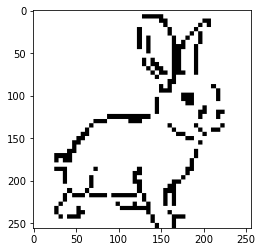

151


In [79]:
def draw(img_fn, n_x_strokes=20, n_y_strokes=20, width=128, combine_strokes=True):
    img = cv2.imread(img_fn, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (width, width)) # we want bgr
    
    painting = np.ones(img.shape)

    strokes = []
    
    # loop through the patches, get the color and add it to the list
    for x_start in np.arange(0., 1., 1./n_x_strokes):
        x_end = x_start + (1./n_x_strokes)
        prev_patch_drawn = False
        
        for y_start in np.arange(0., 1., 1./n_y_strokes):
#             if y_start > 0.33 or x_start > 0.3: continue
            y_end = y_start + (1./n_y_strokes)
            
            patch = img[int(x_start*width):int(x_end*width), int(y_start*width):int(y_end*width), :]

            if np.mean(patch) > 0.8 * 255:
                prev_patch_drawn = False
                continue # -1 if black, else don't draw
            
            painting[int(x_start*width):int(x_end*width), int(y_start*width):int(y_end*width), :] = np.zeros(patch.shape)
            
            x0 = (x_start + x_end) / 2
            x1 = (x_start + x_end) / 2
            x2 = (x_start + x_end) / 2
            y0 = y_start 
            y1 = (y_start + y_end) / 2
            y2 = y_end
            
            if combine_strokes and prev_patch_drawn:
                # elongate the stroke, don't make a new one
                prev_stroke = strokes[-1]
                prev_stroke[0:2] = x2, y2
                strokes[-1] = prev_stroke
                continue

            prev_patch_drawn = True
            
            action = np.zeros((13,))

            action[0:6] = [x2, y2, x1, y1, x0, y0]
            action[10:13] = (-1,-1,-1)

            strokes.append(action)
            
    strokes = np.array(strokes)

    plt.imshow(painting[:,:,::-1])
    plt.show()
    cv2.imwrite(os.path.join(output_dir, 'painting.jpg'), painting * 255.)
        
    df = pd.DataFrame(group_strokes_by_color(strokes))

    df.to_csv(os.path.join(output_dir, 'actions.csv'), sep=",", header=False, index=False, float_format='%.5f')

    return strokes

strokes = draw('image/rabbit2.png', n_x_strokes=50, n_y_strokes=50, width=256)
print(len(strokes))

In [39]:
print(len(strokes))

372


In [ ]:
RGB_SCALE = 255
CMYK_SCALE = 100


def rgb_to_cmyk(r, g, b):
    if (r, g, b) == (0, 0, 0):
        # black
        return 0, 0, 0, CMYK_SCALE

    # rgb [0,255] -> cmy [0,1]
    c = 1 - r / RGB_SCALE
    m = 1 - g / RGB_SCALE
    y = 1 - b / RGB_SCALE

    # extract out k [0, 1]
    min_cmy = min(c, m, y)
    c = (c - min_cmy) / (1 - min_cmy)
    m = (m - min_cmy) / (1 - min_cmy)
    y = (y - min_cmy) / (1 - min_cmy)
    k = min_cmy

    # rescale to the range [0,CMYK_SCALE]
    return c * CMYK_SCALE, m * CMYK_SCALE, y * CMYK_SCALE, k * CMYK_SCALE
allowed_colors = color_cluster('image/coolin1.jpg', n_colors=10, width=128)
w = 200
for i in range(len(allowed_colors)):
    c = allowed_colors[i] #* 255.
    plt.imshow(np.concatenate((np.ones((w,w,1))*c[2], np.ones((w,w,1))*c[1], np.ones((w,w,1))*c[0]), axis=-1))
    plt.show()
    c = c * 255.
    print(c)
    print(rgb_to_cmyk(color_rgb[2], color_rgb[1], color_rgb[0]))

In [ ]:
# !python3 arduino_paint.py --instructions_file=deterministic_paint_instructions/actions.csv